<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/CV_3__P1__UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

Image segmentation is a process of dividing an image into multiple regions or segments based on the characteristics of pixels. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries in images. It is a commonly used technique in digital image processing and analysis to partition an image into multiple parts or regions, often based on the characteristics of the pixels in the image. Image segmentation could involve separating foreground from background, or clustering regions of pixels based on similarities in color or shape. By dividing an image into segments, you can process only the important segments of the image instead of processing the entire image. Image segmentation impacts a number of domains, from the filmmaking industry to the field of medicine. For instance, it is used in medical imaging to detect and label pixels in an image or voxels of a 3D volume that represent a tumor in a patient's brain or other organs.


### UNET

UNet is a convolutional neural network architecture designed for semantic image segmentation, particularly in biomedical images. It was first introduced by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015. The architecture of UNet can be broadly thought of as an encoder network followed by a decoder network. Unlike classification, where the end result of the deep network is the only important thing, semantic segmentation requires discrimination at the pixel level and a mechanism to project the discriminative features learned at different stages of the encoder onto the pixel space. UNet is a fully convolutional neural network with an encoder-decoder structure that has been adapted to incorporate other convolutional neural network architecture designs. The UNet architecture has been used in various domains, including medical imaging.

### UNET Architecture

#### Double Convolution

If we take a closer look at the model architecture, we can find that there are always two consecutive convolutional blocks.
After the input image tile, we have two 3x3 2D convolutions with followed by ReLU.

After every 2D Max Pooling layer, we have two 2D convolutional layers. You can see the downward red arrow followed by two blue arrows in the contracting path of the UNet.

This is even true for the expanding path. Here, we have the up-convolution (green arrow). Following this are two blue arrows representing the two 2D convolutional layers.

So, instead of writing these consecutive convolutional manually each time, we can put them in a function and call them.


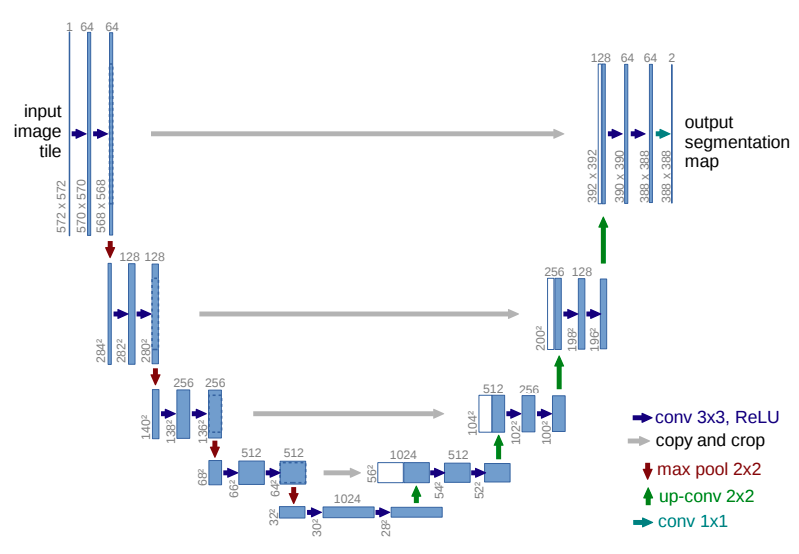

In [1]:
import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )
    return conv_op

We can see a Sequential block with two Conv2d layers followed by ReLU activation. We are using a padding of 1 for each of the convolutional layers. The padding ensures that the final segmentation map is the same size as the input image.

### UNET Class



*   In the `init` method, we begin by defining a MaxPool2d layer, which we'll apply after every downsampling module.

*   The contracting path, mirrors the architecture described in the paper. We use the double_convolution function with the appropriate number of in_channels and out_channels. This starts with 64 out_channels in the initial layer and gradually increases to 1024 out_channels just before transitioning to the expanding path.

*  We also specify the layer configurations for the expanding path, utilizing 2D Transposed Convolutional layers. The first layer in the expanding path reduces the output channels from 1024 to 512. Subsequently, we outline the remaining layer configurations for double_convolution and transposed convolution.

*  Each double_convolution definition in the expanding path doubles the number of in_channels compared to the out_channels of the preceding transposed convolution. Why? It relates to the implementation of skip connections. These connections between the contracting and expanding paths operate along the channel axis. Thus, prior to the double convolutions, the input channels are doubled to accommodate these connections effectively.

* The `forward` method orchestrates the sequential application of all layers in the correct sequence. For each transposed convolutional layer in the expanding path, a double convolution block is employed.

* Commencing with the contracting path, we observe alternating downsampling and max-pooling operations. Adhering to the original UNet design, there is no max-pooling applied after the last downsampling block. This is the point where the number of output channels reaches 1024.

* In the layers for the expanding path, the double convolutions follow the transposed convolution layers. Notably, the concatenation process operates in reverse order. In other words, the first transposed convolutional layer concatenates along the channel axis with the final downsampled block, and this pattern continues.

* The ultimate layer possesses an output channel count equivalent to the number of classes in the dataset. Additionally, since it's a segmentation architecture and we require the final feature map without spatial resolution reduction, the last layer almost always employs a kernel size of 1.



In [2]:
class UNet(nn.Module):
    """
    Implementation of a U-Net architecture for semantic segmentation.

    Args:
        num_classes (int): Number of classes for the segmentation task.

    Attributes:
        max_pool2d (nn.MaxPool2d): Max pooling layer for downsampling.
        down_convolution_1 to down_convolution_5 (nn.Module): Double convolution blocks for the contracting path.
        up_transpose_1 to up_transpose_4 (nn.ConvTranspose2d): Transposed convolution layers for the expanding path.
        up_convolution_1 to up_convolution_4 (nn.Module): Double convolution blocks for the expanding path.
        out (nn.Conv2d): Output convolution layer with 'num_classes' output channels.

    Methods:
        forward(x): Forward pass of the U-Net model.

    The U-Net architecture consists of a contracting path that captures context and an expanding path that enables precise
    localization. Skip connections between corresponding layers in the contracting and expanding paths help preserve
    detailed information.

    This implementation includes five double convolution blocks in the contracting path and corresponding transposed
    convolution and double convolution blocks in the expanding path. The output layer has 'num_classes' channels for
    semantic segmentation.

    Note:
    - The `forward` method computes the forward pass of the U-Net and returns the segmentation output along with a list
      of intermediate layer output sizes for visualization or analysis.
    - The number of input channels is assumed to be 3, typically for RGB images.

    References:
    - Original U-Net Paper: https://arxiv.org/abs/1505.04597
    """

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)
        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    """
    Forward pass of the U-Net model.

    Args:
        x (torch.Tensor): Input tensor, typically an image.

    Returns:
        out (torch.Tensor): Segmentation output tensor.
        layer_outputs (list): List of intermediate layer output sizes for analysis.
    """
    def forward(self, x):
        layer_outputs = []
        down_1 = self.down_convolution_1(x)
        layer_outputs.append(down_1.size())
        down_2 = self.max_pool2d(down_1)
        layer_outputs.append(down_2.size())
        down_3 = self.down_convolution_2(down_2)
        layer_outputs.append(down_3.size())
        down_4 = self.max_pool2d(down_3)
        layer_outputs.append(down_4.size())
        down_5 = self.down_convolution_3(down_4)
        layer_outputs.append(down_5.size())
        down_6 = self.max_pool2d(down_5)
        layer_outputs.append(down_6.size())
        down_7 = self.down_convolution_4(down_6)
        layer_outputs.append(down_7.size())
        down_8 = self.max_pool2d(down_7)
        layer_outputs.append(down_8.size())
        down_9 = self.down_convolution_5(down_8)
        layer_outputs.append(down_9.size())
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        layer_outputs.append(x.size())
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        layer_outputs.append(x.size())
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        layer_outputs.append(x.size())
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        layer_outputs.append(x.size())
        out = self.out(x)
        layer_outputs.append(out.size())
        return out, layer_outputs


In [3]:
input_image = torch.rand((1, 3, 512, 512))
model = UNet(num_classes=10)  # 9 +1background
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
output, layer_sizes = model(input_image)

31,032,330 total parameters.
31,032,330 training parameters.


### Layer Outputs

We can see how the input size changes while being passed through each layer.

In [4]:
print(output.shape)
# Print dimensions after each layer
for i, size in enumerate(layer_sizes):
    print(f"Layer {i+1} output size: {size}")
print(f"Final output size: {output.size()}")

torch.Size([1, 10, 512, 512])
Layer 1 output size: torch.Size([1, 64, 512, 512])
Layer 2 output size: torch.Size([1, 64, 256, 256])
Layer 3 output size: torch.Size([1, 128, 256, 256])
Layer 4 output size: torch.Size([1, 128, 128, 128])
Layer 5 output size: torch.Size([1, 256, 128, 128])
Layer 6 output size: torch.Size([1, 256, 64, 64])
Layer 7 output size: torch.Size([1, 512, 64, 64])
Layer 8 output size: torch.Size([1, 512, 32, 32])
Layer 9 output size: torch.Size([1, 1024, 32, 32])
Layer 10 output size: torch.Size([1, 512, 64, 64])
Layer 11 output size: torch.Size([1, 256, 128, 128])
Layer 12 output size: torch.Size([1, 128, 256, 256])
Layer 13 output size: torch.Size([1, 64, 512, 512])
Layer 14 output size: torch.Size([1, 10, 512, 512])
Final output size: torch.Size([1, 10, 512, 512])


## Image Segmentation

Binary Segmentation : Process of classifying the pixels of an image into two categories: pixels belonging to foregroung objects of an image and pixels belonging to the background objects of an image

We will be using <b> segmentation-models-pytorch </b> a pytorch library for training segmentation models.

In [5]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

### Imports

In [6]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

### Dataset Loading
We will using the SimpleOxfordPetDataset.

The SimpleOxfordPetDataset is a dataset commonly used in computer vision tasks, particularly for image segmentation. It is derived from the Oxford-IIIT Pet Dataset, which contains images of various cat and dog breeds with pixel-level annotations for accurate object segmentation.

The "Simple" version of this dataset typically simplifies the task by focusing on binary or multi-class segmentation (e.g., distinguishing pets from the background or segmenting pets into a few predefined classes like "cat" and "dog"). It's often used for educational purposes or as a starting point for experimenting with segmentation models due to its smaller size and simplified annotation.

In [7]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset
root = "."

SimpleOxfordPetDataset.download(root)

images.tar.gz: 100%|██████████| 755M/755M [00:32<00:00, 24.5MB/s]
annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:03<00:00, 5.19MB/s]


### Dataset

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training. PyTorch provides built-in datasets like MNIST, CIFAR-10, and ImageNet, but custom datasets can also be created to work with specific data.

In [8]:
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

In [9]:
print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 3312
Valid size: 368
Test size: 3669


### Dataloaders

Dataloaders, are utilities that enable efficient data loading and batching. They take a dataset as input and allow users to define batch sizes, shuffle the data, and apply transformations to the samples. Dataloaders are especially useful when dealing with large datasets, as they enable the model to process data in small batches, reducing memory requirements and speeding up training. They are key components in PyTorch that facilitate data handling and preparation for machine learning tasks.

In [10]:
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

### Plotting some images from the Datasets

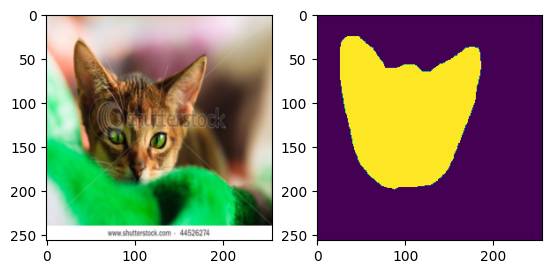

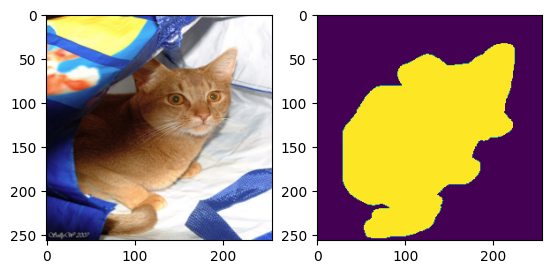

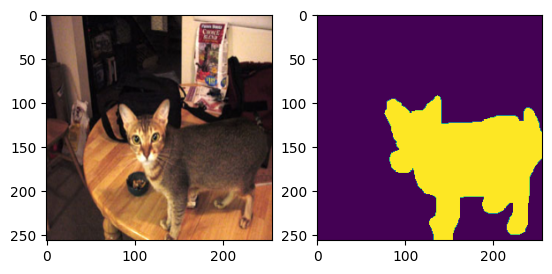

In [12]:
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # For visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # For visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # For visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # For visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # For visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # For visualization we have to remove 3rd dimension of mask
plt.show()

### Model Creation

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
class PetModel(nn.Module):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()

        self.model = smp.create_model(arch, encoder_name = encoder_name, in_channels = in_channels, classes = out_classes, **kwargs)

        # preprocessing params for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.std = torch.tensor(params["std"]).view(1,3,1,1)
        self.std = self.std.to(device)
        self.mean = torch.tensor(params["mean"]).view(1,3,1,1)
        self.mean = self.mean.to(device)


        # For Image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits = True )


    def forward(self, image):
        # normalise image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

An instance of the PetModel class is being created below. This class is designed for semantic segmentation tasks in the context of pet image analysis. The segmentation model architecture being used is specified as "FPN," and the encoder architecture is set to "resnet34."

Arguments:

* "FPN": This is the architecture identifier for a Feature Pyramid Network, a type of neural network commonly used for object detection and segmentation tasks.
* "resnet34": This indicates the choice of the ResNet-34 architecture as the encoder. ResNet (Residual Network) is a popular deep neural network architecture known for its effectiveness in image-related tasks.
* in_channels=3: This specifies that the input images have three channels, typically representing RGB color channels.
* out_classes=1: This parameter sets the number of output classes for the segmentation task, which is 1 in this case, implying binary segmentation where the goal is to distinguish between one class (e.g., "object" vs. "background").

The resulting model object can be used for training, validation, and testing of the segmentation model on pet images, with the specified architecture and encoder settings.

In [15]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 27.0MB/s]


In [16]:
model = model.to(device)

### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

For Image segmentation dice loss could be the best first choice.

In [17]:
loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits = True )

### Learning Rate

The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.

In [18]:
lr=0.0001

### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
def calculate_metrics(metrics, stage="train"):
    # aggregate step metrics
    tp = torch.cat([x["tp"] for x in metrics])
    fp = torch.cat([x["fp"] for x in metrics])
    fn = torch.cat([x["fn"] for x in metrics])
    tn = torch.cat([x["tn"] for x in metrics])


    # Per image IoU, calculate IoU score for each image and then compute mean
    per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro-imagewise")

    dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction = "micro")

    metrics = {
        f"{stage}_per_image_iou" : per_image_iou.cpu().item(),
        f"{stage}_dataset_iou" : dataset_iou.cpu().item()
    }
    return metrics

In [21]:
def train_batch(epoch, model, optimizer, loss_history, metric_history):
    print("epoch ", epoch)
    model.train()
    train_loss = 0
    step_metrics = []

    for batch_idx, batch in enumerate(train_dataloader):
        image = batch["image"]
        # shape of the image should be (batch_size, num_channels, height, width)
        h, w = image.shape[2:]
        mask = batch["mask"]

        image = image.to(device)
        mask = mask.to(device)

        logits_mask = model(image)

        # Predicted mask contains logits and loss_fn param
        loss = loss_fn(logits_mask, mask)

        # compute metrics for some threshold
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = 'binary')
        metrics = {
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn" : tn
        }

        step_metrics.append(metrics)

    metrics = calculate_metrics(step_metrics)
    metric_history.append(metrics)
    loss_history.append(train_loss)
    print( 'Train Loss: %.3f'
                         % (train_loss/(batch_idx+1)))

    print("Train Metrics: ", metrics)




In [22]:
def validate_batch(epoch, model, loss_history, metric_history):
    global best_acc
    model.eval()
    val_loss = 0
    step_metrics = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(valid_dataloader):
            image = batch["image"]
            # shape of the image should be (batch_size, num_channels, height, width)
            h, w = image.shape[2:]
            mask = batch["mask"]

            image = image.to(device)
            mask = mask.to(device)
            logits_mask = model(image)

            # Predicted mask contains logits and loss_fn param
            loss = loss_fn(logits_mask, mask)

            # compute metrics for some threshold
            prob_mask = logits_mask.sigmoid()
            pred_mask = (prob_mask > 0.5).float()

            val_loss += loss.item()

            tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode = 'binary')
            metrics = {
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn" : tn
            }

            step_metrics.append(metrics)


    metrics = calculate_metrics(step_metrics, "val")
    metric_history.append(metrics)
    loss_history.append(val_loss)
    print('Val Loss: %.3f'
                 % (val_loss/(batch_idx+1)))
    print("Val Metrics: ", metrics)

### Training

In [23]:
start_epoch = 0
train_loss_history = []
val_loss_history = []
train_metric_history = []
val_metric_history = []
for epoch in range(start_epoch, start_epoch+15):
    train_batch(epoch, model, optimizer, train_loss_history, train_metric_history)
    validate_batch(epoch, model, val_loss_history, val_metric_history)


epoch  0
Train Loss: 0.090
Train Metrics:  {'train_per_image_iou': 0.8304998874664307, 'train_dataset_iou': 0.8362557888031006}
Val Loss: 0.063
Val Metrics:  {'val_per_image_iou': 0.875552237033844, 'val_dataset_iou': 0.8866347074508667}
epoch  1
Train Loss: 0.051
Train Metrics:  {'train_per_image_iou': 0.8958917260169983, 'train_dataset_iou': 0.9056400656700134}
Val Loss: 0.055
Val Metrics:  {'val_per_image_iou': 0.8913414478302002, 'val_dataset_iou': 0.8991438746452332}
epoch  2
Train Loss: 0.043
Train Metrics:  {'train_per_image_iou': 0.9097639322280884, 'train_dataset_iou': 0.9195479154586792}
Val Loss: 0.054
Val Metrics:  {'val_per_image_iou': 0.8917198181152344, 'val_dataset_iou': 0.9016773700714111}
epoch  3
Train Loss: 0.039
Train Metrics:  {'train_per_image_iou': 0.9174659252166748, 'train_dataset_iou': 0.9270150661468506}
Val Loss: 0.051
Val Metrics:  {'val_per_image_iou': 0.898020327091217, 'val_dataset_iou': 0.9073446393013}
epoch  4
Train Loss: 0.037
Train Metrics:  {'trai

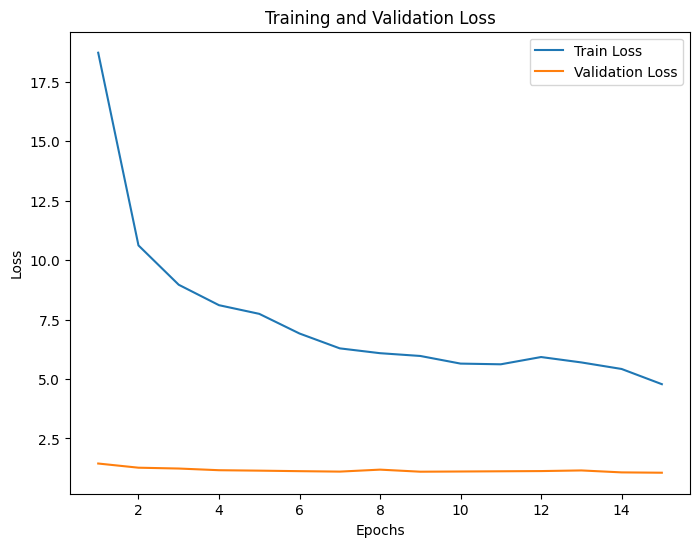

In [24]:
import matplotlib.pyplot as plt

# Plot the loss values using Matplotlib (optional)
epochs = list(range(1, len(train_loss_history) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

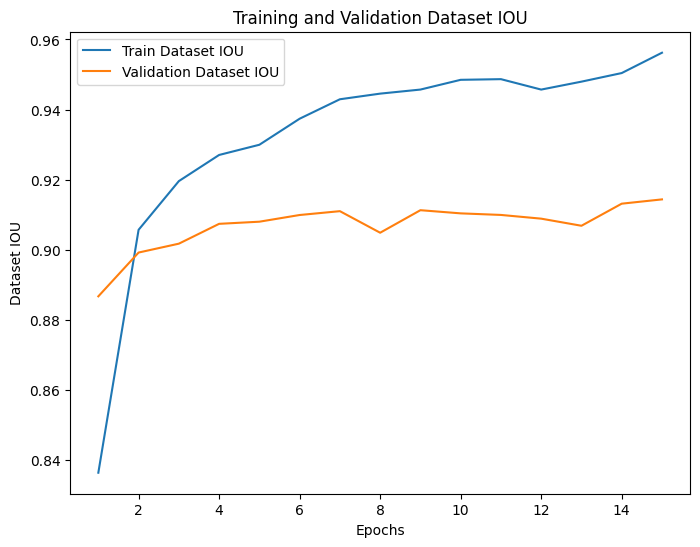

In [25]:
train_dataset_iou = [metric['train_dataset_iou'] for metric in train_metric_history]
val_dataset_iou = [metric['val_dataset_iou'] for metric in val_metric_history]

epochs = list(range(1, len(train_dataset_iou) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_dataset_iou, label='Train Dataset IOU')
plt.plot(epochs, val_dataset_iou, label='Validation Dataset IOU')
plt.xlabel('Epochs')
plt.ylabel('Dataset IOU')
plt.legend()
plt.title('Training and Validation Dataset IOU')
plt.show()

### Plotting Ground Truth versus Prediction

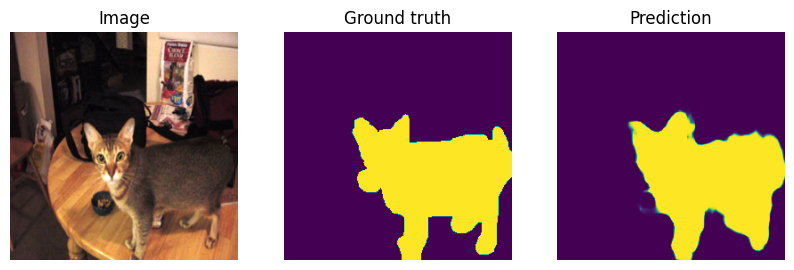

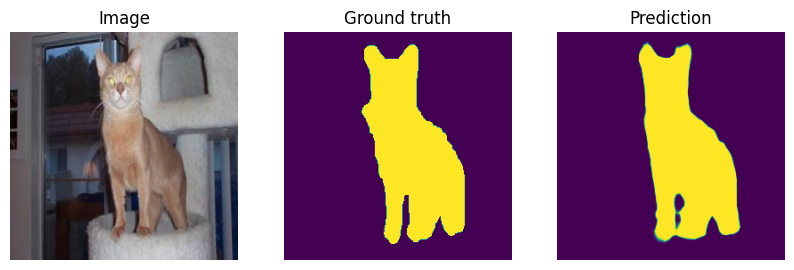

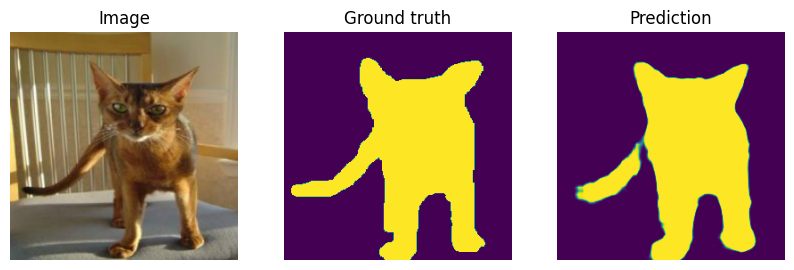

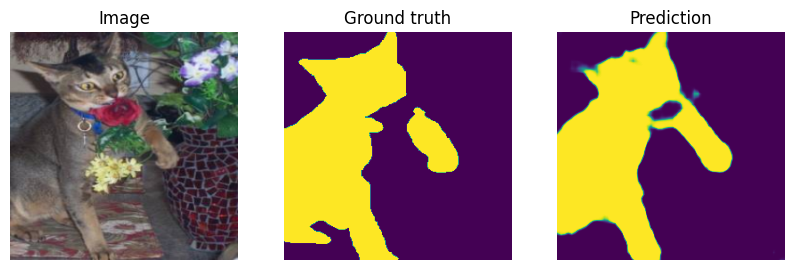

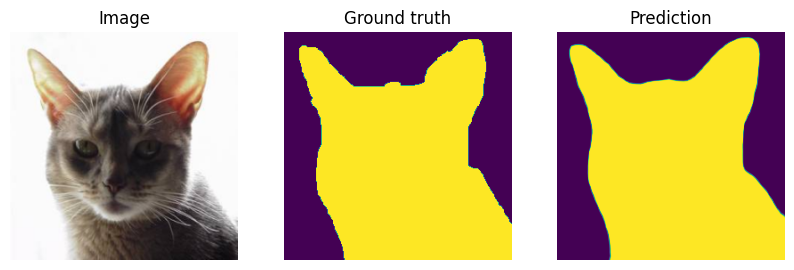

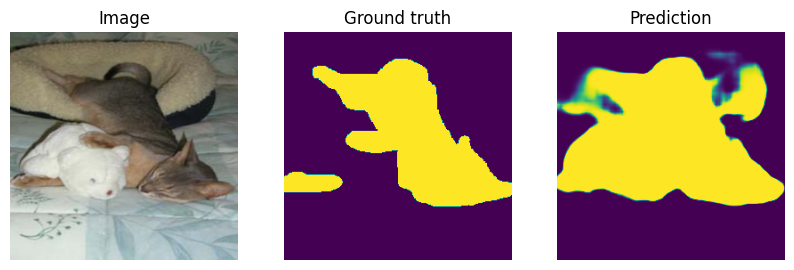

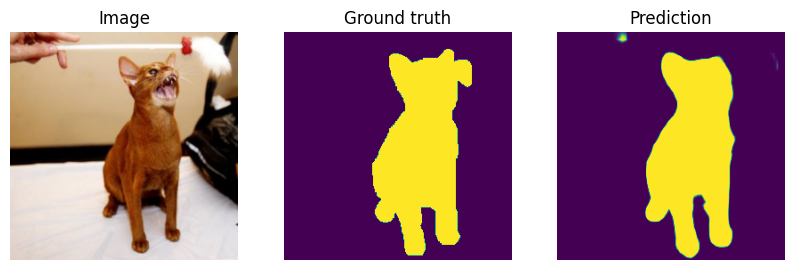

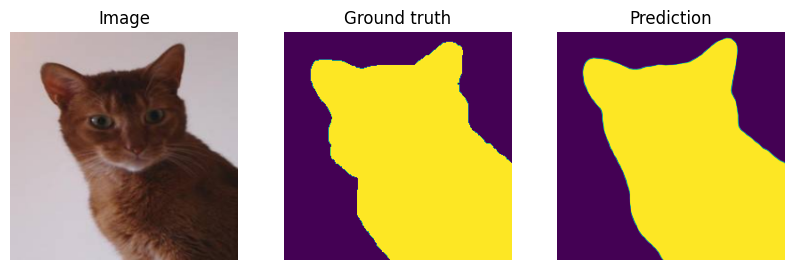

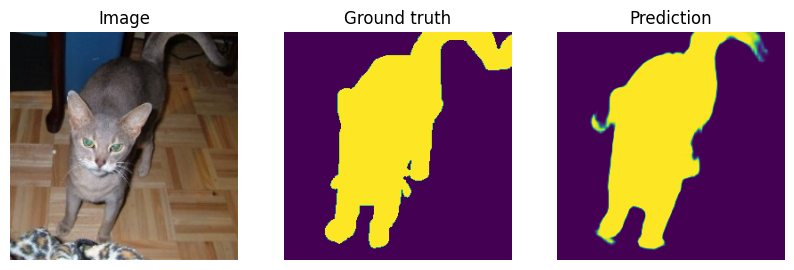

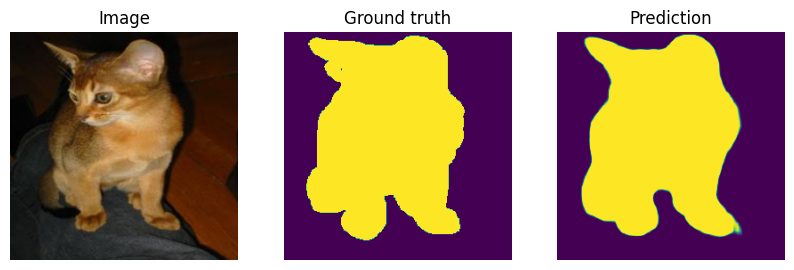

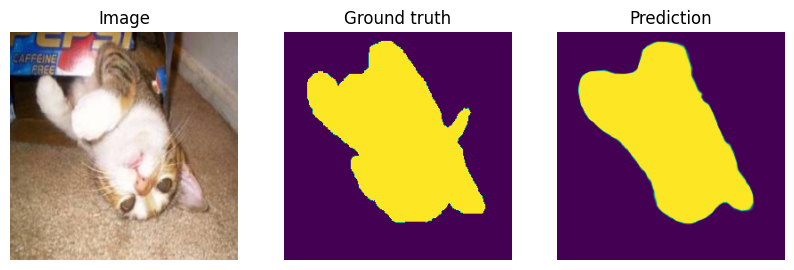

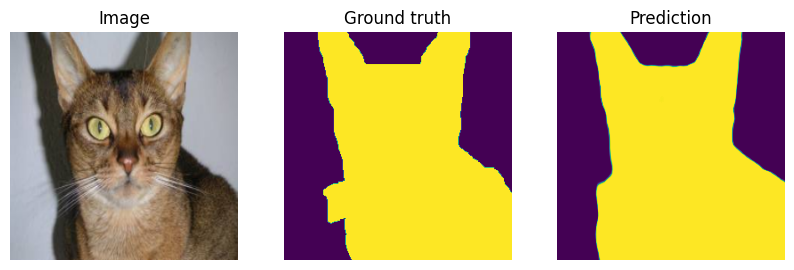

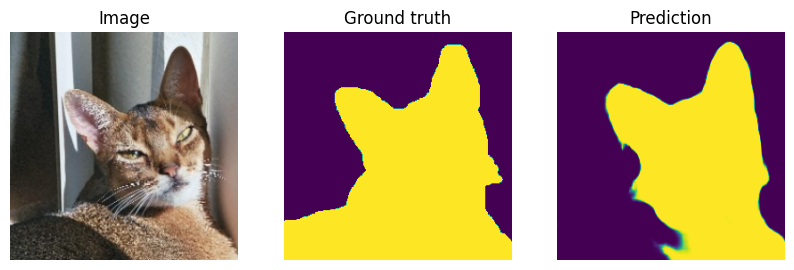

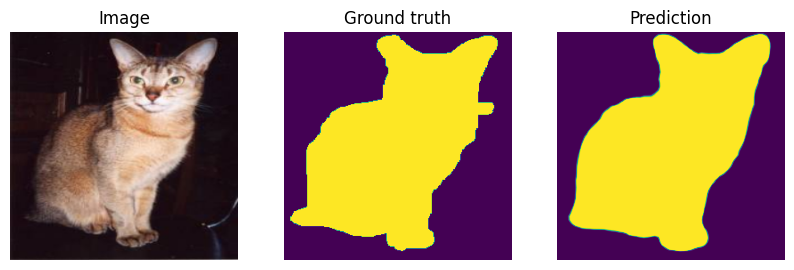

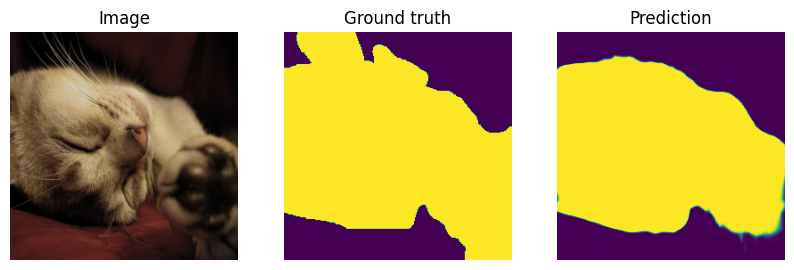

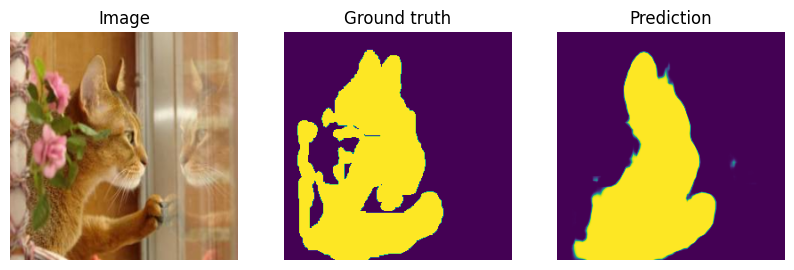

In [26]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    image = batch["image"]
    image = image.to(device)
    logits = model(image)
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.cpu().numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()